In [26]:
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from fastprogress.fastprogress import master_bar, progress_bar


from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [27]:
device = "cuda" 

In [28]:
def get_data_loaders(path, batch_size, valid_batch_size=0):

    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    valid_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [29]:
#class ColorizationNet(nn.Module):
    #def __init__(self):
    #     super(ColorizationNet, self).__init__()
    #     self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu1 = nn.ReLU(True)
    #     self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu2 = nn.ReLU(True)
    #     self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu3 = nn.ReLU(True)
    #     self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu4 = nn.ReLU(True)
    #     self.conv5 = nn.Conv2d(256, 128, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu5 = nn.ReLU(True)
    #     self.conv6 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu6 = nn.ReLU(True)

    # def forward(self, x):
    #     x = nn.functional.relu(self.conv1(x))
    #     x = nn.functional.relu(self.conv2(x))
    #     x = nn.functional.relu(self.conv3(x))
    #     x = nn.functional.relu(self.conv4(x))
    #     x = nn.functional.relu(self.conv5(x))
    #     x = torch.sigmoid(self.conv6(x))
    #     return x

    # def __init__(self):
    #     super(ColorizationNet, self).__init__()
    #     # Reduced from 6 layers → 3 layers
    #     self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu1 = nn.ReLU(True)
        
    #     self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
    #     self.relu2 = nn.ReLU(True)
        
    #     # Directly map to 3 channels (RGB) in the final layer
    #     self.conv3 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)
        
    # def forward(self, x):
    #     x = self.relu1(self.conv1(x))
    #     x = self.relu2(self.conv2(x))
    #     x = torch.sigmoid(self.conv3(x))  # Sigmoid ensures output in [0,1] for RGB
    #     return x






class ColorizationNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),      # [1, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),     # [64, 64, 64, 64]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # [64, 64, 32, 32]

            nn.Conv2d(64, 128, 3, padding=1),    # [64, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),   # [128, 128, 32, 32]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                  # [128, 128, 16, 16]

            nn.Conv2d(128, 256, 3, padding=1),   # [128, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),   # [256, 256, 16, 16]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                   # [256, 256, 8, 8]
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),  # [256, 128, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 2, stride=2),   # [128, 64, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),    # [64, 32, 64, 64]
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=3, padding=1), # [32, 3, 64, 64]
            nn.Sigmoid()  # For output in [0, 1] RGB
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x




# class ColorizationNet(nn.Module):
#   def __init__(self, input_size=128):
#     super(ColorizationNet, self).__init__()
#     resnet = models.resnet34(num_classes=1000)
#     resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
#     self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
#     RESNET_FEATURE_SIZE = 128
#     # Upsampling Network
# # self.upsample = nn.Sequential(     
# #   nn.Conv2d(RESNET_FEATURE_SIZE, 128, kernel_size=3, xstride=1, padding=1),
# #   nn.BatchNorm2d(128),
# #   nn.ReLU(),
# #   nn.Upsample(scale_factor=2),
# #   nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
# #   nn.BatchNorm2d(64),
# #   nn.ReLU(),
# #   nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
# #   nn.BatchNorm2d(64),
# #   nn.ReLU(),
# #   nn.Upsample(scale_factor=2),
# #   nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
# #   nn.BatchNorm2d(32),
# #   nn.ReLU(),
# #   nn.Upsample(scale_factor=2),
# #   nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
# #   nn.BatchNorm2d(16),
# #   nn.ReLU(),
# #   nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1),
# #   nn.Upsample(scale_factor=2)
# # )

#     self.upsample = nn.Sequential(     
#       nn.Conv2d(RESNET_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
#       nn.BatchNorm2d(128),
#       nn.ReLU(),
#       nn.Upsample(scale_factor=2),
#       nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
#       nn.BatchNorm2d(64),
#       nn.ReLU(),
#       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
#       nn.BatchNorm2d(64),
#       nn.ReLU(),
#       nn.Upsample(scale_factor=2),
#       nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
#       nn.BatchNorm2d(32),
#       nn.ReLU(),
#       nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
#       nn.BatchNorm2d(16),
#       nn.ReLU(),
#       nn.Conv2d(16, 3, kernel_size=3, stride=1, padding=1), # Output has 2 channels instead of 3 because we are
#                                                           # predicting a and b channels of Lab color space instead of RGB
#       nn.Upsample(scale_factor=2)
#     )

#   def forward(self, input):
#     midlevel_features = self.midlevel_resnet(input)
#     output = self.upsample(midlevel_features)
#     return output




In [30]:
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True)

In [31]:
def plot_losses(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
data_path = "~/data"

train_batch_size = 128
valid_batch_size = 5000
train_loader, valid_loader = get_data_loaders(
    data_path, train_batch_size, valid_batch_size
)

Files already downloaded and verified
Files already downloaded and verified


Epoch [1/15], Step [1/391], Loss: 0.0340
Epoch [1/15], Step [101/391], Loss: 0.0079
Epoch [1/15], Step [201/391], Loss: 0.0068
Epoch [1/15], Step [301/391], Loss: 0.0054
Epoch [1/15], Step [1/2], Val Loss: 0.0054
Epoch [1/15], Avg Train Loss: 0.0077, Avg Val Loss: 0.0054
Epoch [2/15], Step [1/391], Loss: 0.0049
Epoch [2/15], Step [101/391], Loss: 0.0046
Epoch [2/15], Step [201/391], Loss: 0.0044
Epoch [2/15], Step [301/391], Loss: 0.0041
Epoch [2/15], Step [1/2], Val Loss: 0.0043
Epoch [2/15], Avg Train Loss: 0.0045, Avg Val Loss: 0.0043
Epoch [3/15], Step [1/391], Loss: 0.0037
Epoch [3/15], Step [101/391], Loss: 0.0040
Epoch [3/15], Step [201/391], Loss: 0.0036
Epoch [3/15], Step [301/391], Loss: 0.0041
Epoch [3/15], Step [1/2], Val Loss: 0.0039
Epoch [3/15], Avg Train Loss: 0.0041, Avg Val Loss: 0.0039
Epoch [4/15], Step [1/391], Loss: 0.0035
Epoch [4/15], Step [101/391], Loss: 0.0040
Epoch [4/15], Step [201/391], Loss: 0.0039
Epoch [4/15], Step [301/391], Loss: 0.0036
Epoch [4/15], 

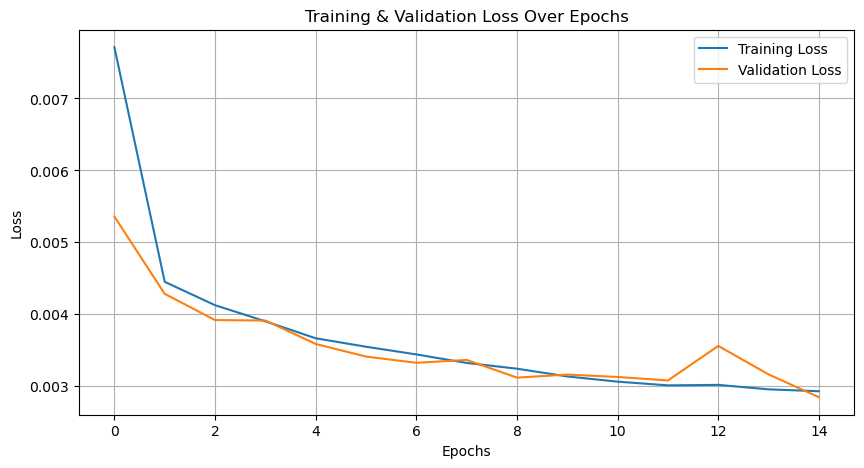

In [33]:
# Training loop
EPOCHS = 15

model = ColorizationNet().to(device)

criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

train_losses = []
valid_losses = []

for epoch in range(EPOCHS):
    device = "cuda" 
    model.train()  # Set model to training mode
    epoch_train_loss = 0.0
    
    for i, (images, _) in enumerate(train_loader):
        device = "cuda" 
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass
        outputs = model(grayscale_images)
        loss = criterion(outputs, images)
        epoch_train_loss += loss.item()

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    epoch_valid_loss = 0.0
    
    with torch.no_grad():
        for i, (images, _) in enumerate(valid_loader):
            device = "cuda" 
            grayscale_images = rgb_to_gray(images).to(device)
            images = images.to(device)
            
            colorized_images = model(grayscale_images)
            valid_loss = criterion(colorized_images, images)
            epoch_valid_loss += valid_loss.item()
            
            if i % 100 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(valid_loader)}], Val Loss: {valid_loss.item():.4f}")
    
    # Calculate average validation loss for the epoch
    avg_valid_loss = epoch_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Avg Train Loss: {avg_train_loss:.4f}, Avg Val Loss: {avg_valid_loss:.4f}")

print("Finished Training")

# Plot the losses
plot_losses(train_losses, valid_losses)

# for epoch in range(EPOCHS):
#     for i, (images, _) in enumerate(train_loader):
#         grayscale_images = rgb_to_gray(images).to(device)
#         images = images.to(device)

#         # Forward pass
#         outputs = model(grayscale_images)
#         loss = criterion(outputs, images)

#         # Backward pass and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Print statistics
#         if i % 100 == 0:
#             print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
#     with torch.no_grad():
#         for i, (images, _) in enumerate(valid_loader):
#             grayscale_images = rgb_to_gray(images).to(device)
#             colorized_images = model(grayscale_images)
            
#             valid_loss = criterion(colorized_images, images)
            
#             if i % 100 == 0:
#                 print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(valid_loader)}], Loss: {valid_loss.item():.4f}")

# print("Finished Training")

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=4):
    """
    Display grayscale, colorized, and original images side by side.
    n: number of images to display from the batch
    """
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        # Display colorized image
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


# def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
#     """
#     Displays n rows with 3 columns each: Original | Grayscale | Colorized
#     """
#     fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

#     for i in range(n):
#         # Original
#         ax = axes[i, 0]
#         ax.imshow(original_images[i])
#         ax.set_title("Original")
#         ax.axis("off")

#         # Grayscale
#         ax = axes[i, 1]
#         ax.imshow(grayscale_images[i], cmap='gray')
#         ax.set_title("Grayscale")
#         ax.axis("off")

#         # Colorized
#         ax = axes[i, 2]
#         ax.imshow(colorized_images[i])
#         ax.set_title("Colorized")
#         ax.axis("off")

#     plt.tight_layout()
#     plt.show()



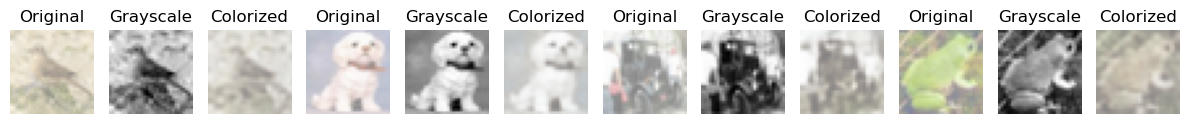

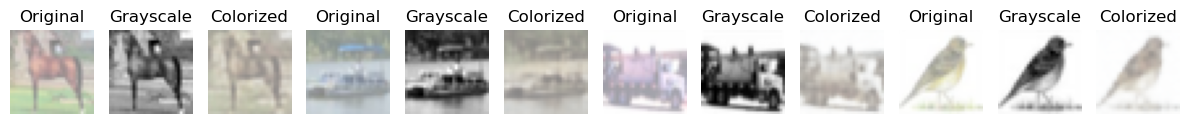

In [35]:
with torch.no_grad():
    for i, (images, _) in enumerate(valid_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)

        # Convert the tensors back to CPU for visualization
        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)  # remove the color channel
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()

        #colorized_images_cpu=scale_predicted_colors(colorized_images_cpu)
        
        #colorized_images_cpu=exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:  # only do this for up to certain batch for demonstration purposes
            break

In [36]:
torch.save(model.state_dict(), 'model.pth')

In [37]:
# def colorize(image):
    
    
#     grayscale_image = rgb_to_gray(image).to(device) #ensure it's grayscale, send to device
    
#     with torch.no_grad():
#         colorized_image = model(grayscale_image)
    
#     # Convert tensors to numpy arrays and prepare for plotting
#     grayscale_np = grayscale_image.squeeze().cpu().numpy().transpose(1, 2, 0)
#     colorized_np = colorized_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    
#     # Clip values to [0,1] range if needed
#     colorized_np = np.clip(colorized_np, 0, 1)
    
#     # Plot images
#     plt.figure(figsize=(10, 5))
    
#     plt.subplot(1, 2, 1)
#     plt.imshow(grayscale_np.squeeze(), cmap='gray')
#     plt.title('Grayscale Input')
#     plt.axis('off')
    
#     plt.subplot(1, 2, 2)
#     plt.imshow(colorized_np)
#     plt.title('Colorized Output')
#     plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()
    
#     return colorized_image

    

In [5]:
# torch.save(model.state_dict(), 'model_weights1.pth')

In [6]:
# # Load the image using PIL
# image_pil = Image.open("elephants.jpg")  

# # Convert to tensor and normalize
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts to [0,1] range and (C, H, W)
# ])
# image_tensor = transform(image_pil).unsqueeze(0)  # Add batch dimension

# # Pass to the colorizer function
# colorized_output = colorize(image_tensor)

In [51]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def colorize_single_image(model, image_path, device='cuda'):
    """
    Colorizes a single grayscale image using the trained PyTorch model.

    Parameters:
        model: Trained PyTorch colorization model.
        image_path: Path to the input grayscale image.
        device: 'cuda' or 'cpu'

    Displays:
        Original grayscale and colorized RGB images.
    """
    model.eval()
    model.to(device)

    # Load and preprocess image
    img = Image.open(image_path).convert('L')  # Load in grayscale
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 1, 64, 64]

    # Forward pass through model
    with torch.no_grad():
        output = model(img_tensor)[0].cpu()  # Shape: [3, 64, 64]

    # Convert tensors to images
    colorized = np.transpose(output.numpy(), (1, 2, 0))  # [64, 64, 3]
    colorized = np.clip(colorized, 0, 1)

    # Show grayscale and colorized images
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.title("Grayscale Input")
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Colorized Output")
    plt.imshow(colorized)
    plt.axis('off')

    plt.show()

/tmp/ipykernel_129223/3015462350.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


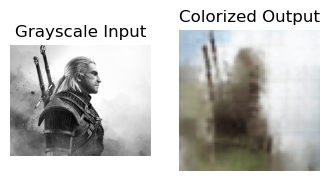

In [55]:
image_path = 'geralt.png'
model = ColorizationNet()  # Your model class must be defined first
model.load_state_dict(torch.load('model.pth'))
model.eval()
colorize_single_image(model, image_path)